In [1]:
#loading packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import pickle

%matplotlib inline

In [2]:
#loading the dataset
airline_train = pd.read_csv('data/train.csv')
airline_test  = pd.read_csv('data/test.csv')

In [3]:
#setting max_columns =25 and displaying first 5 rows
pd.set_option('display.max_columns',25)

airline_train.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,satisfied


In [4]:
#lowering the strings and replacing space with _
airline_train.columns= airline_train.columns.str.lower().str.replace(' ','_')
airline_test.columns= airline_test.columns.str.lower().str.replace(' ','_')

In [5]:
airline_train.dtypes

unnamed:_0                             int64
id                                     int64
gender                                object
customer_type                         object
age                                    int64
type_of_travel                        object
class                                 object
flight_distance                        int64
inflight_wifi_service                  int64
departure/arrival_time_convenient      int64
ease_of_online_booking                 int64
gate_location                          int64
food_and_drink                         int64
online_boarding                        int64
seat_comfort                           int64
inflight_entertainment                 int64
on-board_service                       int64
leg_room_service                       int64
baggage_handling                       int64
checkin_service                        int64
inflight_service                       int64
cleanliness                            int64
departure_

In [6]:
#dropping unnamed:_0 and id columns from dataframe
airline_train.drop(columns=['unnamed:_0','id'], inplace=True)
airline_test.drop(columns=['unnamed:_0','id'], inplace=True)

#dropping the duplicate rows
airline_train = airline_train.drop_duplicates()
airline_test = airline_test.drop_duplicates()

- Training dataset consists 103904 records and 23 columns

In [7]:
#storing all numerical feature names to numerical variable
#storing all categorical feature names to categorical variable and class attribute
#storing all ordinal feature names except type_of_travel
numerical = ['age', 'flight_distance', 'departure_delay_in_minutes', 'arrival_delay_in_minutes']
categorical = airline_train.select_dtypes(include='object').columns.values
ordinal = [column for column in airline_train.columns.values \
               if column not in numerical and column not in categorical]

In [8]:
#lowering all the strings object columns in dataframe and replacing space with _
for column in categorical:
    airline_train[column] = airline_train[column].str.lower().str.replace(' ','_')
    airline_test[column] = airline_test[column].str.lower().str.replace(' ','_')

In [9]:
no_of_null = airline_train.isnull().sum()

In [10]:
#checking whether the features has null values
no_train_null = airline_train.isnull().sum()
print("Features with null values in training dataset:", no_train_null[no_train_null!=0])
print("% of null values for each feature that has null values:",
      no_train_null[no_train_null!=0]/airline_train.shape[0])


no_test_null = airline_test.isnull().sum()
print("Features with null values in test dataset:", no_test_null[no_test_null!=0])
print("% of null values for each feature that has null values:", 
      no_test_null[no_test_null!=0]/airline_test.shape[0])

Features with null values in training dataset: arrival_delay_in_minutes    310
dtype: int64
% of null values for each feature that has null values: arrival_delay_in_minutes    0.002984
dtype: float64
Features with null values in test dataset: arrival_delay_in_minutes    83
dtype: int64
% of null values for each feature that has null values: arrival_delay_in_minutes    0.003195
dtype: float64


- Approximately 0.003 % of the train and test data has null values.
- We have the null values only in arrival_delay_in_minutes
- Feature arrival_delay_in_minutes has 310 observations with null values
- As we have huge dataset we could go ahead and remove them but even in the test set we have null values so instead of removing them we could replace the values with the mean value of training set.

In [11]:
#replace null values instead of 0
arrival_delay_mean= np.mean(airline_train.arrival_delay_in_minutes)
airline_train.arrival_delay_in_minutes = airline_train.arrival_delay_in_minutes.fillna(arrival_delay_mean)
airline_test.arrival_delay_in_minutes = airline_test.arrival_delay_in_minutes.fillna(arrival_delay_mean)


null_vals_train = airline_train.isnull().sum()
null_vals_test = airline_test.isnull().sum()
print("No. of null values:", null_vals_train.sum(), null_vals_test.sum())

No. of null values: 0 0


In [12]:
print("Airline train data shape: ",airline_train.shape)
print("Airline test data shape: ",airline_test.shape)

Airline train data shape:  (103904, 23)
Airline test data shape:  (25976, 23)


- In the training dataset we have 103904 records and 23 features.
- In the test dataset we have 25976 records.
- Numerical features:  ['age', 'flight_distance', 'departure_delay_in_minutes', 'arrival_delay_in_minutes']
- Categorical features + 'class' : ['gender', 'customer_type', 'type_of_travel', 'class', 'satisfaction']
- Ordinal : ['inflight_wifi_service', 'departure/arrival_time_convenient', 'ease_of_online_booking', 'gate_location', 'food_and_drink', 'online_boarding', 'seat_comfort', 'inflight_entertainment', 'on-board_service', 'leg_room_service', 'baggage_handling', 'checkin_service', 'inflight_service', 'cleanliness']

<a id='visualizations'></a>
### Visualizations

In [13]:
def plot_pie(features,df):
    
    length = len(features)

    columns = 3
    rows = round(length/3)
    fig, ax =plt.subplots(rows, columns, figsize=(10,10))

    for idx in range(length):

        feature = features[idx]

        value_counts = df[feature].value_counts()
        labels = value_counts.index
        counts = value_counts.values

        r =  int(idx/columns)
        c = idx%columns
        plt.sca(ax[r,c])
        plt.title("Pie chart for {}".format(feature))
        plt.pie(counts,labels=labels, autopct='%1.f%%')

    if rows*columns != length:
        fig.delaxes(ax[rows-1][columns-1])
    plt.tight_layout()
    plt.show()

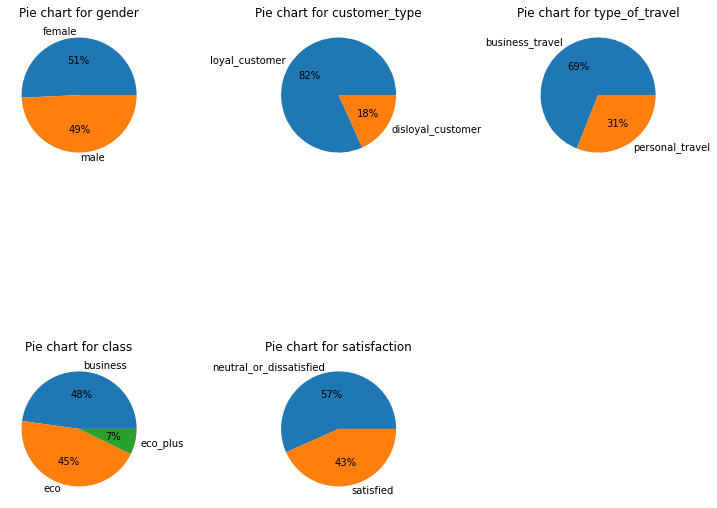

In [14]:
length = len(categorical)
rows = np.ceil(length/3)+ length%3
plot_pie(categorical, airline_train)

## Analysis:
- From the above pie charts we can say that the following features are not sampled correctly.
    - Class (Economy / Economy Plus / Business)
    - Customer Type (Loyal / Disloyal)
    - Type of Travel (Business / Personal Travel)
    
- We don't have much information about people who has travelled in economy plus.
- We have very less opinions of disloyal customers when compared to loyal customers.
- Of the feedback collected, 70% of the people travels for business and only 30% of the people travels for personal.
- We can consider the given problem as a balanced problem as we have 43% people who are satisfied and 57% people who are either satisfied(1) or neutral/dissatisfied(0).



In [15]:
def bar_ordinal_cat(ordinal, feature, df):

    plt.figure(figsize=(10,8))
    categorical_and_sat = np.concatenate((ordinal,[feature]))
    data = pd.melt(df[categorical_and_sat],id_vars=feature,
                        var_name='services',
                        value_name='rating')
    sns.barplot(y='services',x='rating', hue=feature, data=data)
    plt.show()

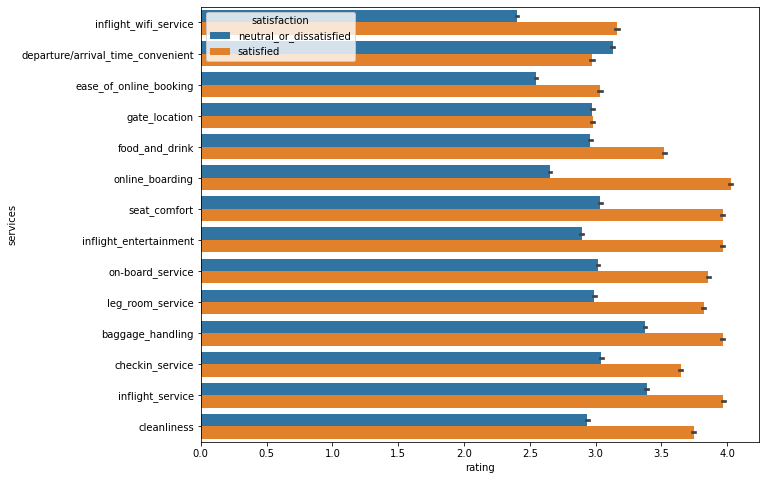

In [16]:
bar_ordinal_cat(ordinal,'satisfaction',airline_train)

- From above plot we can say that the probability of satisfaction for people is more when the rating for services is above 3.0

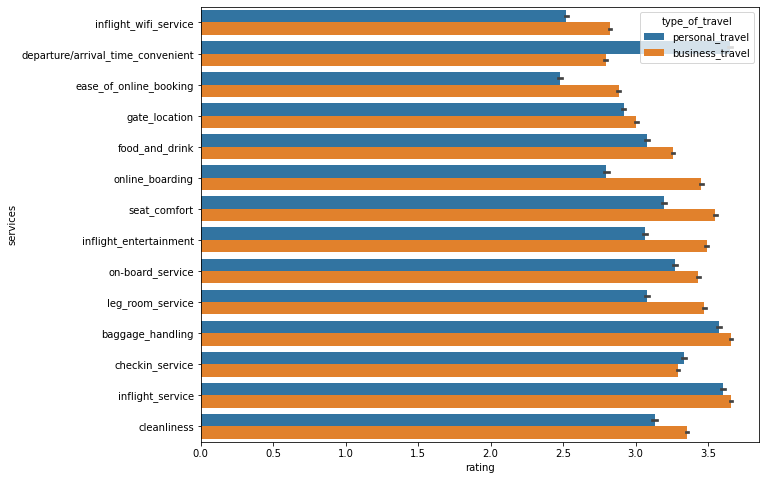

In [17]:
bar_ordinal_cat(ordinal,'type_of_travel',airline_train)

- From this plot, we can say that people who travelled for business purpose has given higher rating when compared to the people who travelled for personal.
- We can also observe that business travel people gave low rating for departure/arrival_time convenience compared to personal travel people.
- We also see that the personal travel people gave low rating for online boarding when compared to business travel people.

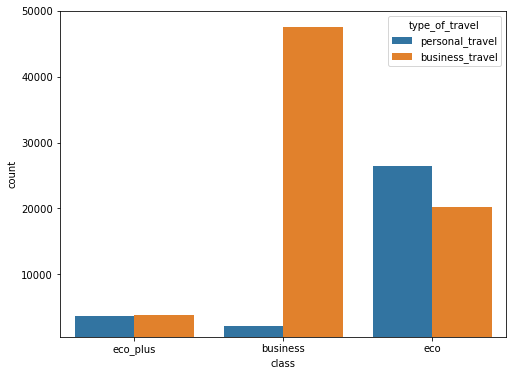

In [18]:
plt.figure(figsize=(8,6))
plot=sns.countplot(x='class',hue='type_of_travel', data=airline_train)
plt.ylim(500,50000)
plt.show()

- From above we can conclude that the business travel people have travelled mostly in business class whereas the personal travel people have travlled mostly in economy or economy plus.
- As airline give higher preference when boarding the business people compared to the economy or economy plus we can observe the reduction in rating for online boarding by personal travel people.
- As all the services will be better for business class people we can see in above bar plot that almost all the services has received higher rating by business travel when compared to personal travel people except for departure/arrival time convenience.


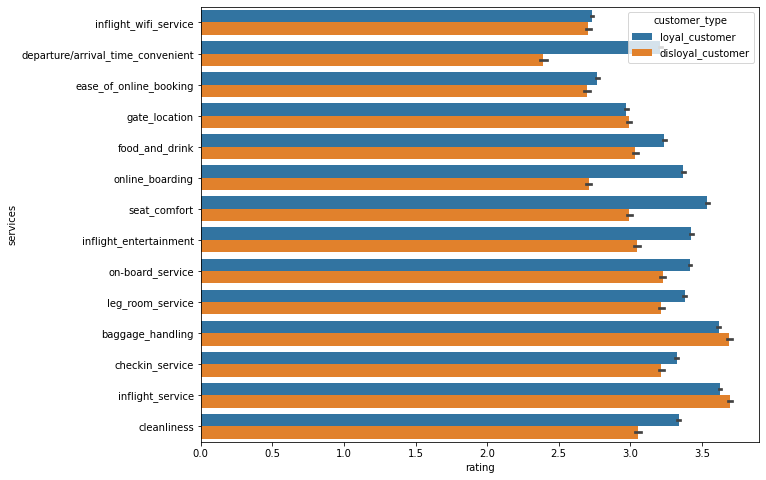

In [19]:
bar_ordinal_cat(ordinal,'customer_type',airline_train)

- Loyal customers gave higher rating for almost all the services compared to disloyal customers.
- Disloyal customers gave very low rating to departure/arrival_time_convenience, online boarding, clealiness, inflight_wifi_service and seat_comfort.
- Both loyal and disloyal customers are not happy with inflight_wifi_service.

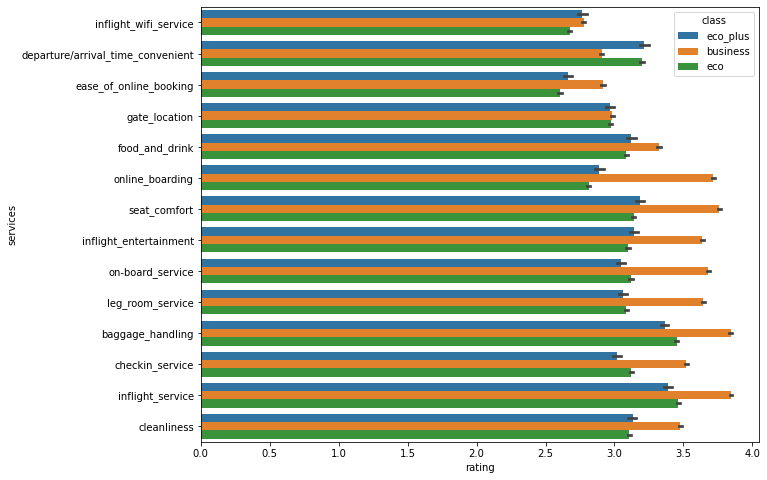

In [20]:
bar_ordinal_cat(ordinal,'class',airline_train)

- This is as expected people who travel through economy class gave low rating for almost all the services when compared to the business class.
- And I think it is not wise to bring economy plus into picture as we have very low data regarding them.

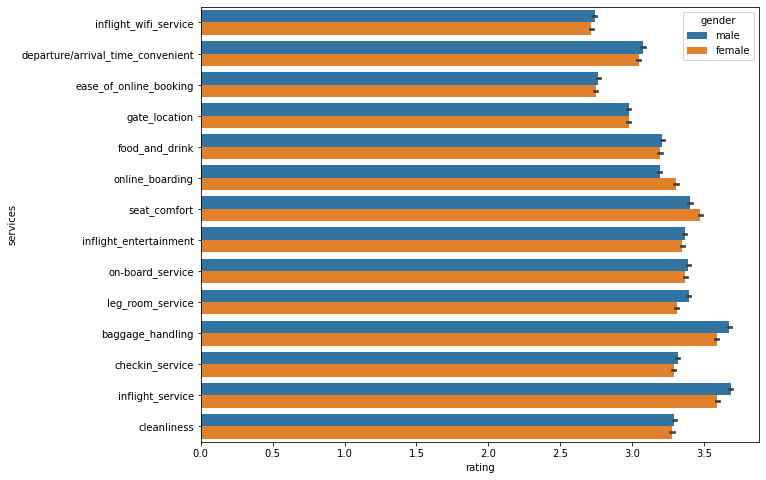

In [21]:
bar_ordinal_cat(ordinal,'gender',airline_train)

- Both male and females gave similar rating to all the services
- They are very happy with baggage handling and inflight service.
- They are not at all happy with online booking service.
- Age feature is not providing much information to differeniate male and females. 

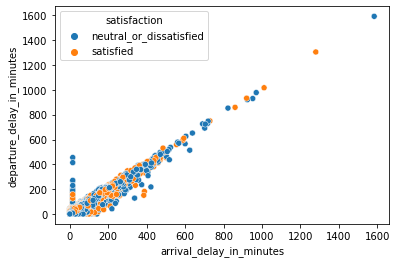

In [22]:
sns.scatterplot(x='arrival_delay_in_minutes', y='departure_delay_in_minutes', hue='satisfaction', data=airline_train)
plt.show()

- From above we can say that the arrival_delay_in_minutes and departure_delay_in_minutes are positively correlated. 
- We can drop one of these features.

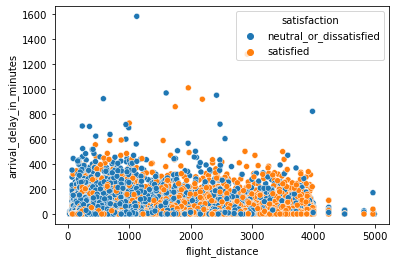

In [23]:
sns.scatterplot(x='flight_distance', y='arrival_delay_in_minutes', hue='satisfaction', data=airline_train)
plt.show()

- We can't observe any particular pattern b/w flight distance and arrival_delay_in_minutes.

In [24]:
def point_and_box(feature1, feature2, df):
    fig,ax= plt.subplots(1,2,figsize=(15,8))
    
    plt.sca(ax[0])
    sns.pointplot(x=feature1, y=feature2,data=df)

    plt.sca(ax[1])
    sns.boxplot(x=feature1, y=feature2, data=df)
    
    plt.show()

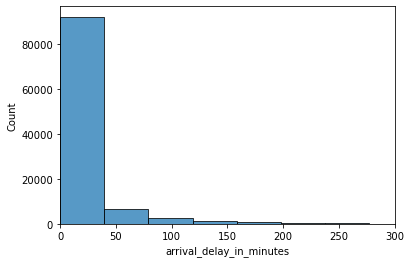

In [25]:
sns.histplot(x='arrival_delay_in_minutes',bins=40, data=airline_train)
plt.xlim(0,300)
plt.show()

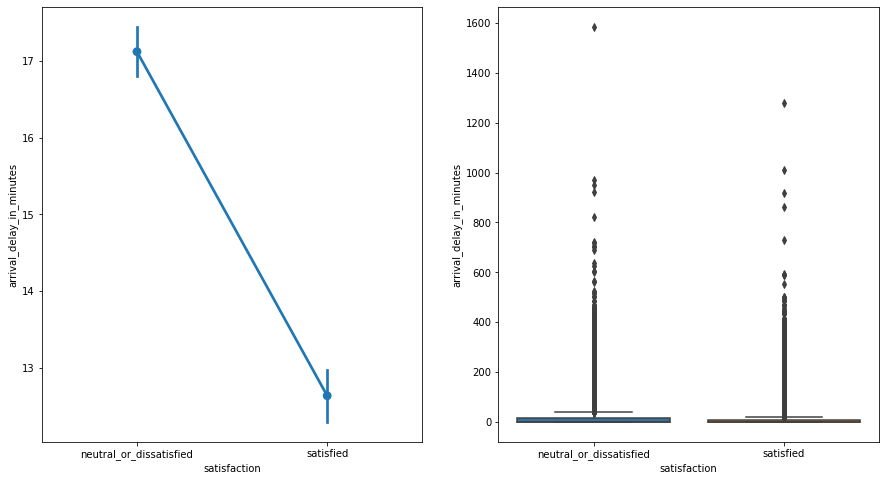

In [26]:
point_and_box('satisfaction','arrival_delay_in_minutes', airline_train)

- We can observe that as the arrival delay increase the customer dissatisfaction increases.
- 75% of the time arrival delay is less than 40 minutes.

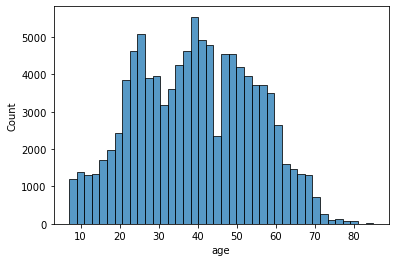

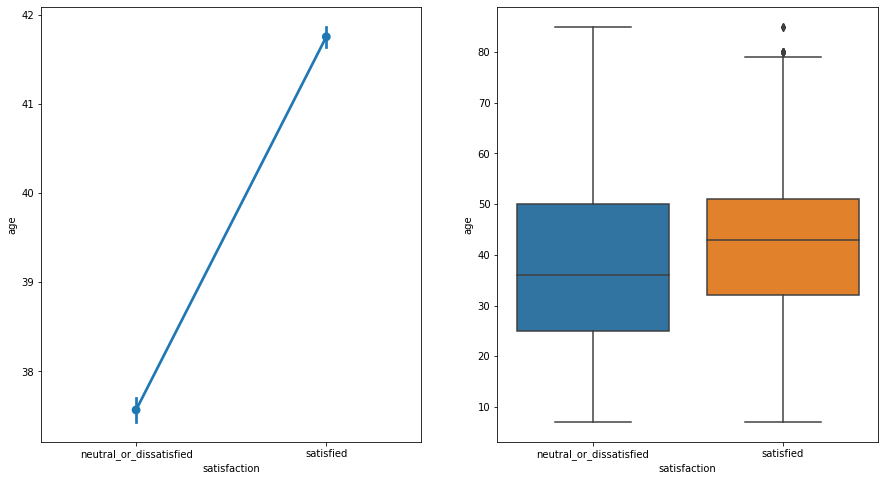

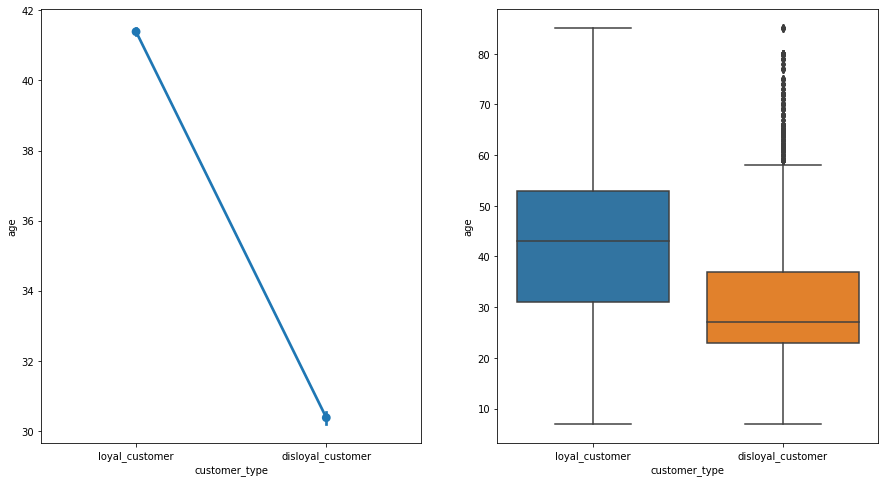

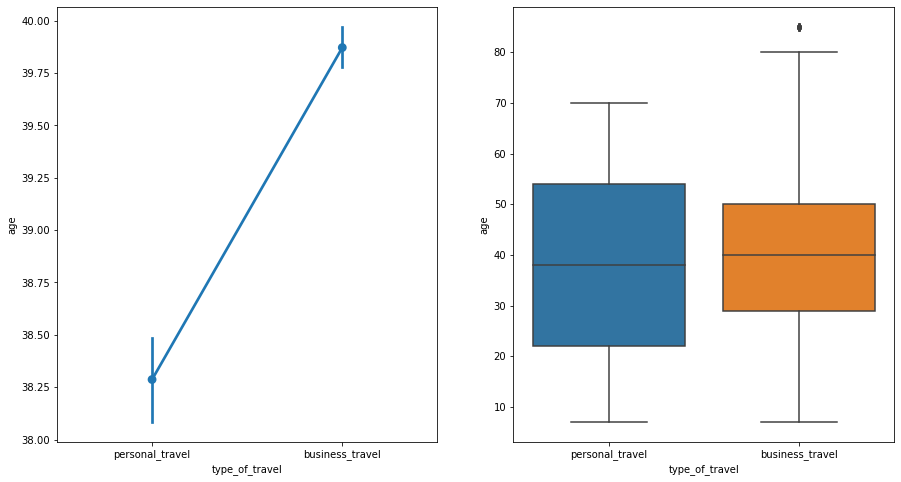

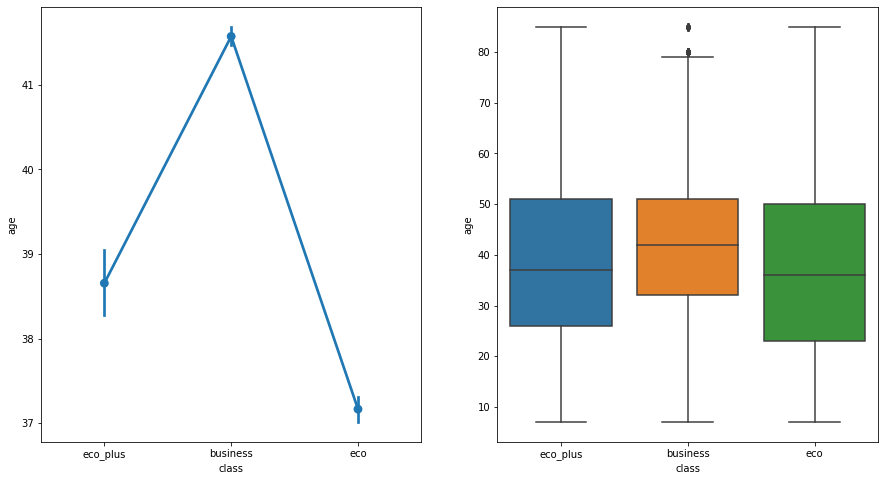

In [27]:
sns.histplot(x='age',bins=40, data=airline_train)
plt.show()
point_and_box('satisfaction', 'age', airline_train)
point_and_box('customer_type', 'age', airline_train)
point_and_box('type_of_travel', 'age', airline_train)
point_and_box('class', 'age', airline_train)

- From above histplot we can say that people who travel has a median age of 40.
- More people are aged above 40.
- Average age of people who are satisfied is more than the people who are not satisfied.
- Average age of loyal customer is higher than the disloyal customer.
- Older people travel more for business compared to younger.
- Older people travel more in business class compared to younger.

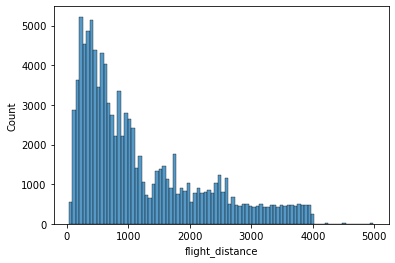

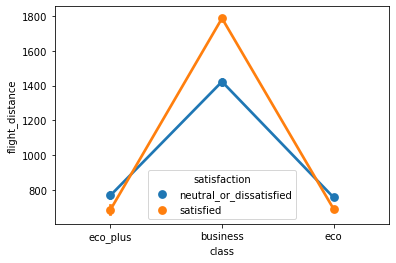

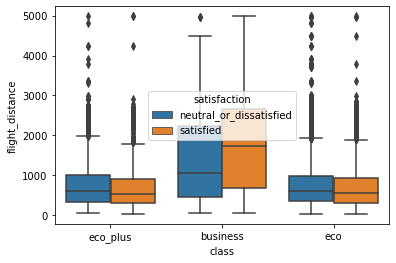

In [28]:
sns.histplot(x='flight_distance',data=airline_train)
plt.show()
sns.pointplot(x='class', y='flight_distance',hue='satisfaction',data=airline_train)
plt.show()
sns.boxplot(x='class', y='flight_distance',hue='satisfaction', data=airline_train)
plt.show()

- Distribution of flight distance is right_skewed.
- Satisfaction is high for larger distances. This is because more people have opted for business class when the flight distance is large.

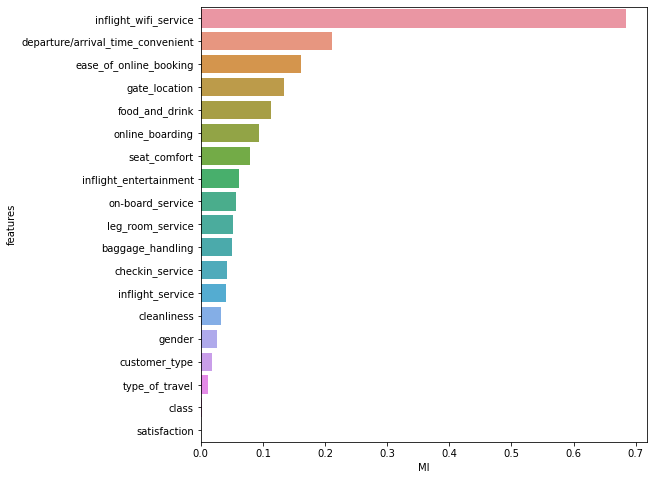

In [29]:
#get the mutual info scores and correlation with target variable
from sklearn.metrics import mutual_info_score

def calculate_mi(series):
    return mutual_info_score(series, airline_train.satisfaction)

categorical_ord = np.concatenate((ordinal,categorical))
df_mi = airline_train[categorical_ord].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')
df_mi.index = categorical_ord 

df_mi['features'] = df_mi.index
df_mi = df_mi.reset_index(drop=True)
column_names =['features', 'MI']
df_mi = df_mi.reindex(columns=column_names)


plt.figure(figsize=(8,8))
sns.barplot(x='MI', y='features', data= df_mi)
plt.show()

- From above we can see that the inflight_wifi_service gives more information about the satisfaction of a customer.
- class is not providing any information about the satisfaction of a customer

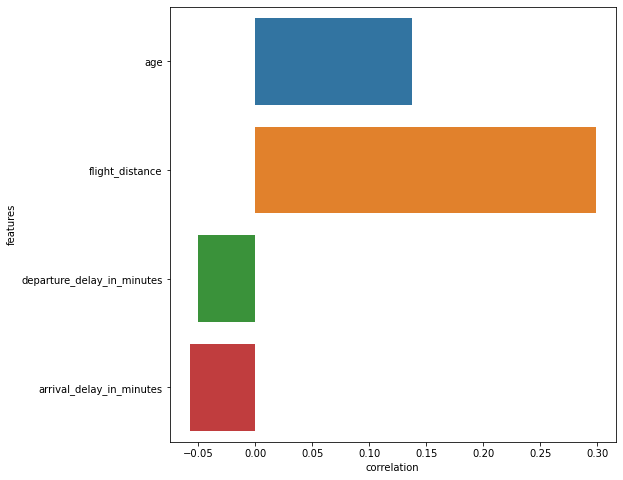

In [30]:
airline_train.satisfaction = airline_train.satisfaction.map({'neutral_or_dissatisfied':0,'satisfied':1})
airline_test.satisfaction = airline_test.satisfaction.map({'neutral_or_dissatisfied':0,'satisfied':1})



df_corr = airline_train[numerical].corrwith(airline_train.satisfaction)

df_corr = df_corr.to_frame(name='correlation') 

df_corr['features'] = df_corr.index
df_corr = df_corr.reset_index(drop=True)
column_names =['features', 'correlation']
df_corr = df_corr.reindex(columns=column_names)



plt.figure(figsize=(8,8))
sns.barplot(x='correlation', y='features', data= df_corr)
plt.show()

In [31]:
#dropping departure_delay_in_minutes and class columns from dataframe
airline_train.drop(columns=['departure_delay_in_minutes', 'class'], inplace=True)
airline_test.drop(columns=['departure_delay_in_minutes', 'class'], inplace=True)

- Lets drop departure_delay_in_minutes and keep arrival_delay_in_minutes as it is more correlated to the target variable

In [32]:
y = airline_train.satisfaction.values
y_test = airline_test.satisfaction.values

airline_train.drop(columns=['satisfaction'], inplace=True)
airline_test.drop(columns=['satisfaction'], inplace=True)

### Preparing Training Data

In [33]:
df_train, df_val, y_train, y_val = train_test_split(airline_train,y, test_size=0.3, stratify=y, random_state=1)

train_dict = df_train.to_dict(orient='records')
dv = DictVectorizer()
dv.fit(train_dict)

X_train = dv.transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = airline_test.to_dict(orient='records')
X_test = dv.transform(test_dict)

results = []

In [34]:
def train(Xtrain,y_train, C):
    
    
    model = LogisticRegression(solver='liblinear', C=C, random_state=1)
    model.fit(Xtrain,y_train)
    
    return model


def predict(model,Xval):
    
    val_proba = model.predict_proba(Xval)[:,1]
    
    return val_proba

In [35]:
def get_C_for_logistic(nfolds,C_vals,dv,df,y):

    kfold = KFold(n_splits=nfolds,shuffle=True, random_state=1)
    auc_scores =[]
    for C in C_vals:
        aucs=[]
        for train_index,val_index in kfold.split(df):
            df_train,df_val = df.iloc[train_index], df.iloc[val_index] 
            y_train, y_val = y[train_index], y[val_index]
            
            train_dict = df_train.to_dict(orient='records')
            X_train = dv.transform(train_dict)
            
            val_dict = df_val.to_dict(orient='records')
            X_val = dv.transform(val_dict)
            
            logistic_model = train(X_train, y_train, C)
            y_predict = predict(logistic_model,X_val)
            auc= roc_auc_score(y_val, y_predict)
            aucs.append(auc)
        print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))
        auc_scores.append([C, round(np.mean(aucs),3), round(np.std(aucs),3)])
    
    df_auc = pd.DataFrame(auc_scores, columns=['C','mean', 'std'])
    df_auc = df_auc.sort_values(by=['mean','std'], ascending=[False, True], ignore_index=True)
    
    best_C =df_auc.head(1)['C'].values[0]
    return best_C

In [36]:
C = get_C_for_logistic(5,[0.001, 0.01, 0.1, 0.5, 1, 10], dv, airline_train, y)
print("Best C for logistic regression:", C)

logistic_model = train(X_train, y_train, C)


train_pred = predict(logistic_model, X_train)
train_auc = round(roc_auc_score(y_train, train_pred),3)
train_acc = round(accuracy_score(y_train,train_pred>0.5),3)

val_pred = predict(logistic_model, X_val)
val_auc = round(roc_auc_score(y_val, val_pred),3)
val_acc = round(accuracy_score(y_val,val_pred>0.5),3)

test_pred = predict(logistic_model, X_test)
test_auc = round(roc_auc_score(y_test, test_pred),3)
test_acc = round(accuracy_score(y_test,test_pred>0.5),3)

results.append(['Logistic_Regression',train_auc, train_acc, val_auc, val_acc, test_auc, test_acc])
results

C=0.001, auc = 0.913 ± 0.001
C=0.01, auc = 0.925 ± 0.001
C=0.1, auc = 0.925 ± 0.001
C=0.5, auc = 0.925 ± 0.001
C=1, auc = 0.925 ± 0.001
C=10, auc = 0.925 ± 0.001
Best C for logistic regression: 0.01


[['Logistic_Regression', 0.924, 0.872, 0.925, 0.874, 0.924, 0.87]]

### Decision Tree

In [37]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth, random_state=1)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.792
   2 -> 0.868
   3 -> 0.924
   4 -> 0.951
   5 -> 0.966
   6 -> 0.977
  10 -> 0.986
  15 -> 0.973
  20 -> 0.953
None -> 0.943


- We observe that when depth is in between 5-10 it gave good results 

In [38]:
scores = []

for depth in [6,8,10,12,15]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s, random_state=1)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))
        
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc                            
max_depth            6      8      10     12     15
min_samples_leaf                                   
1                 0.977  0.984  0.986  0.983  0.973
5                 0.977  0.984  0.986  0.986  0.981
10                0.977  0.984  0.987  0.987  0.984
15                0.977  0.984  0.987  0.987  0.985
20                0.977  0.984  0.988  0.988  0.987
100               0.977  0.983  0.986  0.987  0.988
200               0.976  0.981  0.984  0.984  0.985
500               0.975  0.979  0.980  0.980  0.980

<AxesSubplot:xlabel='None-max_depth', ylabel='min_samples_leaf'>

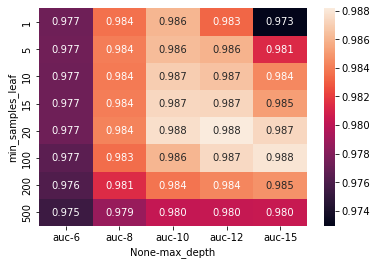

In [39]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

- From above we can say that we got the maximum auc when depth=12 and min_samples_leaf=15

In [40]:
dt = DecisionTreeClassifier(max_depth=12, min_samples_leaf=20, random_state=1)
dt.fit(X_train, y_train)

train_pred = dt.predict_proba(X_train)[:, 1]
train_auc = round(roc_auc_score(y_train, train_pred),3)
train_acc = round(accuracy_score(y_train,train_pred>0.5),3)

val_pred = dt.predict_proba(X_val)[:, 1]
val_auc = round(roc_auc_score(y_val, val_pred),3)
val_acc = round(accuracy_score(y_val,val_pred>0.5),3)
     
test_pred = dt.predict_proba(X_test)[:, 1]
test_auc = round(roc_auc_score(y_test, test_pred),3)
test_acc = round(accuracy_score(y_test,test_pred>0.5),3)

results.append(['Decision_Tree',train_auc, train_acc, val_auc, val_acc, test_auc, test_acc])

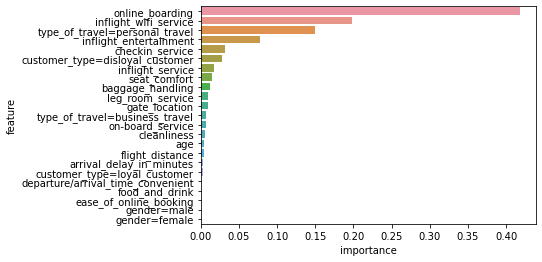

In [41]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.get_feature_names_out()
df_importances['importance'] = dt.feature_importances_
df_importances = df_importances.sort_values(by='importance', ascending=False)


sns.barplot(y='feature', x='importance', data=df_importances)
plt.show()

- Online_boarding, inflight_wifi_service and type_of_travel are the most important features for Decision Tree model.

### Random Forest

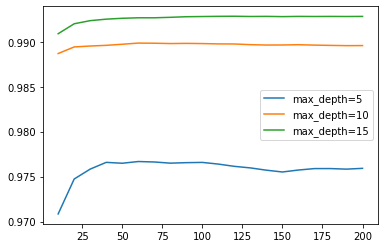

In [42]:
scores = []

for d in [5, 10, 15, 20]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))
        
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)


for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

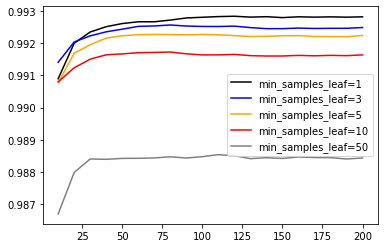

In [43]:
max_depth = 15

scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))
        
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [44]:
min_samples_leaf = 3


rf = RandomForestClassifier(n_estimators=75,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)

train_pred = rf.predict_proba(X_train)[:, 1]
train_auc = round(roc_auc_score(y_train, train_pred),3)
train_acc = round(accuracy_score(y_train,train_pred>0.5),3)

val_pred = rf.predict_proba(X_val)[:, 1]
val_auc = round(roc_auc_score(y_val, val_pred),3)
val_acc = round(accuracy_score(y_val,val_pred>0.5),3)


test_pred = rf.predict_proba(X_test)[:, 1]
test_auc = round(roc_auc_score(y_test, test_pred),3)
test_acc = round(accuracy_score(y_test,test_pred>0.5),3)
     
results.append(['Random Forest',train_auc, train_acc, val_auc, val_acc, test_auc, test_acc])

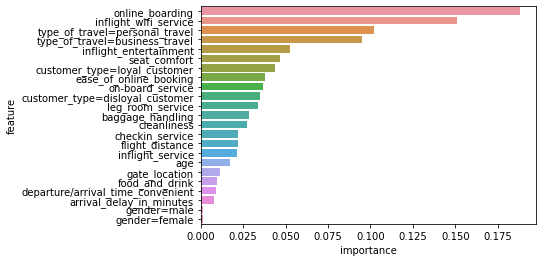

In [45]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.get_feature_names_out()
df_importances['importance'] = rf.feature_importances_
df_importances = df_importances.sort_values(by='importance', ascending=False)


sns.barplot(y='feature', x='importance', data=df_importances)
plt.show()

- Online_boarding, inflight_wifi_service and type_of_travel are the most important features for Random Forest model.

### XGBOOST

In [46]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

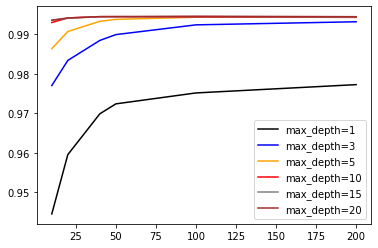

In [47]:
scores=[]

for depth in [1,3,5,10,15,20]:
    for n in [10,20,40,50,100,200]:
        
        xgb_params = {
            'eta': 0.3, 
            'max_depth': depth,
            'min_child_weight': 1,

            'objective': 'binary:logistic',
            'eval_metric': 'auc',

            'nthread': 8,
            'seed': 1,
            'verbosity': 1,
        }

        model = xgb.train(xgb_params, dtrain, num_boost_round=n,
                          verbose_eval=0)

        y_pred = model.predict(dval)
        auc = roc_auc_score(y_val, y_pred)

        scores.append((depth, n, auc))

columns = ['max_depth', 'num_boost_round', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

colors = ['black', 'blue', 'orange', 'red', 'grey', 'brown']
values = [1, 3, 5, 10, 15,20]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.max_depth == s]
    
    plt.plot(df_subset.num_boost_round, df_subset.auc,
             color=col,
             label='max_depth=%d' % s)

plt.legend()
plt.show()

In [48]:
max_depth = 5
n = 130
scores=[]
for eta in [0.01, 0.1, 0.3, 0.5, 1]:
    for min_child in [1,3,5,10,20, 50,100]:
        
        xgb_params = {
            'eta': eta, 
            'max_depth': max_depth,
            'min_child_weight': min_child,

            'objective': 'binary:logistic',
            'eval_metric': 'auc',

            'nthread': 8,
            'seed': 1,
            'verbosity': 1,
        }

        model = xgb.train(xgb_params, dtrain, num_boost_round=n,
                          verbose_eval=0)

        y_pred = model.predict(dval)
        auc = roc_auc_score(y_val, y_pred)

        scores.append((eta, min_child, auc))

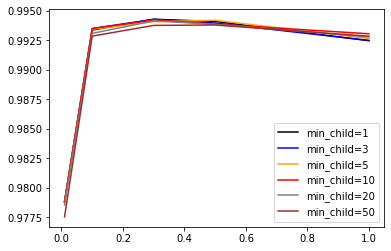

In [49]:
columns = ['eta', 'min_child', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

colors = ['black', 'blue', 'orange', 'red', 'grey', 'brown']
values = [1,3,5,10,20, 50,100]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_child == s]
    
    plt.plot(df_subset.eta, df_subset.auc,
             color=col,
             label='min_child=%d' % s)

plt.legend()
plt.show()

In [50]:
# Final model
eta =  0.1
min_child =  5

xgb_params = {
            'eta': eta, 
            'max_depth': 5,
            'min_child_weight': min_child,

            'objective': 'binary:logistic',
            'eval_metric': 'auc',

            'nthread': 8,
            'seed': 1,
            'verbosity': 1,
        }

model = xgb.train(xgb_params, dtrain, num_boost_round=130,verbose_eval=0)

                  
                  
train_pred = model.predict(dtrain)
train_auc = round(roc_auc_score(y_train, train_pred),3)
train_acc = round(accuracy_score(y_train,train_pred>0.5),3)

val_pred = model.predict(dval)
val_auc = round(roc_auc_score(y_val, val_pred),3)
val_acc = round(accuracy_score(y_val,val_pred>0.5),3)

                
test_pred = model.predict(dtest)
test_auc = round(roc_auc_score(y_test, test_pred),3)
test_acc = round(accuracy_score(y_test,test_pred>0.5),3)                  

results.append(['XGBOOST',train_auc, train_acc, val_auc, val_acc, test_auc, test_acc])

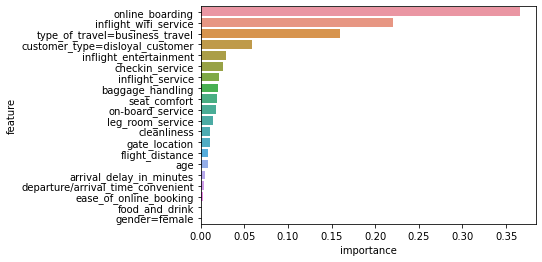

In [51]:
data = model.get_score(importance_type='total_gain')
keys = np.array(list(data.keys())).reshape(-1,1)
values = np.array(list(data.values())).reshape(-1,1)
values = np.concatenate((keys,values), axis=1) 

df_importances = pd.DataFrame(values, columns = ['feature','importance'])
df_importances.importance = df_importances.importance.astype(np.float64)
df_importances.importance = (df_importances.importance)/ (df_importances.importance.sum())

df_importances = df_importances.sort_values(by='importance', ascending=False)


sns.barplot(y='feature', x='importance', data=df_importances)
plt.show()

- Online_boarding, inflight_wifi_service and type_of_travel are the most important features for xgboost model.

- All the trained models has almost similar feature importances. Using EDA, we found out that inflight_wifi_service has high mutual information score but online_boarding is very important feature for modeling when compared to inflight_wifi_service. Type_of_travel attribute also has high impact on all model results.

In [52]:
column_names = ['model','train_auc','train_acc', 'val_auc', 'val_acc','test_auc', 'test_acc']
df_results = pd.DataFrame(results, columns=column_names)
df_results

,model,train_auc,train_acc,val_auc,val_acc,test_auc,test_acc
0,Logistic_Regression,0.924,0.872,0.925,0.874,0.924,0.870
1,Decision_Tree,0.992,0.955,0.988,0.951,0.989,0.951
2,Random Forest,0.997,0.971,0.993,0.959,0.993,0.960
3,XGBOOST,0.994,0.960,0.993,0.959,0.994,0.959


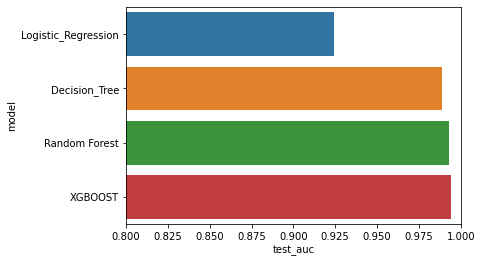

In [53]:
sns.barplot(x='test_auc', y='model', data=df_results)
plt.xlim(0.8,1.0)
plt.show()

- Random Forest and XGBoost gave similar results. But I chose xgboost as the final model as it has less train auc with same test auc when compared with Random Forest.
- As I couldn't install xgboost package using pipenv, I chose to deploy RandomForest model as it has similar results when compared with xgboost model.